In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from dataset import Dataset
from tools import getDataset, print_class_distribution

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
print(torch.__version__)

1.8.2


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [4]:
batch_size = 64
num_workers = 4
learning_rate = 0.0001 
num_epochs = 3
image_size = 224
num_classes = 50

root_dir = os.path.join(os.getcwd(), 'datasets/miniImageNet')
dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes)


train_transforms = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.RandomCrop(image_size, padding=8),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

transforms = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
       
train_dataset, temp_dataset = train_test_split(dataset, test_size=0.4, random_state=42)
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=0.5, random_state=42)
      
train_dataset = Dataset(dataset=train_dataset, path=root_dir, phase='train', transform=train_transforms)
val_dataset = Dataset(dataset=val_dataset, path=root_dir, phase='val', transform=transforms)
test_dataset = Dataset(dataset=test_dataset, path=root_dir, phase='test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing/evaluating -> batch: %d correct: %d numb images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, train_loader, valid_loader):

    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(params= net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, betas=(0.5, 0.999))
    scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        net.train()
        correct = 0.0  # used to accumulate number of correctly recognized images
        num_images = 0.0  # used to accumulate number of images
        total_loss = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output_train = net(images)
            loss = criterion(output_train, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicts = output_train.argmax(dim=1)
            correct += predicts.eq(labels).sum().item()
            num_images += len(labels)
            total_loss += loss.item()

            print('training -> epoch: %d, batch: %d, loss: %f' % (epoch, i_batch, loss.item()) + '\r', end='')

        print()
        acc = correct / num_images
        acc_eval, val_loss = eval(net, valid_loader)
        average_loss = total_loss / len(train_loader)
        training_losses.append(average_loss)
        val_losses.append(val_loss)
        print('\nepoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_eval))

        scheduler.step()

    return net, training_losses, val_losses

Hyperparameters:
Batch Size: 64
Learning Rate: 0.0001
Number of Epochs: 3
Number of Workers: 4

training -> epoch: 0, batch: 281, loss: 0.242224
testing/evaluating -> batch: 93 correct: 5349 numb images: 6000
epoch: 0, lr: 0.000100, accuracy: 0.837500, loss: 0.633862, valid accuracy: 0.891500

training -> epoch: 1, batch: 281, loss: 0.101005
testing/evaluating -> batch: 93 correct: 5369 numb images: 6000
epoch: 1, lr: 0.000100, accuracy: 0.935056, loss: 0.220350, valid accuracy: 0.894833

training -> epoch: 2, batch: 281, loss: 0.095652
testing/evaluating -> batch: 93 correct: 5247 numb images: 6000
epoch: 2, lr: 0.000100, accuracy: 0.952556, loss: 0.149127, valid accuracy: 0.874500

testing/evaluating -> batch: 93 correct: 5318 numb images: 6000
accuracy on testing data: 0.886333


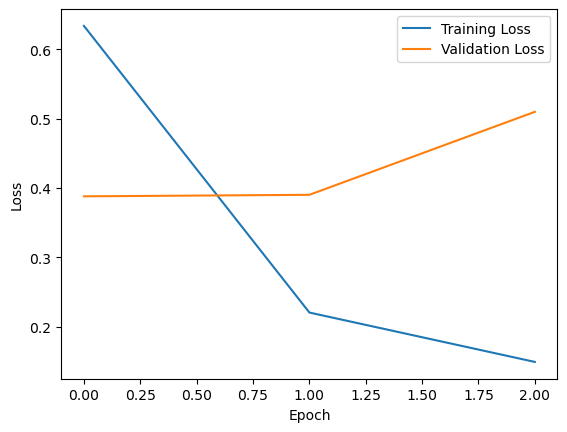

In [6]:
from models.ViT import ViT

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}\n")

# print_class_distribution(train_dataset, "Training", label_mapping)
# print_class_distribution(val_dataset, "Validation", label_mapping)
# print_class_distribution(test_dataset, "Testing", label_mapping)

model = ViT(num_classes=50).to(device)
model, training_losses, val_losses = train(net=model, train_loader=train_loader, valid_loader=validation_loader)

acc_test, test_loss = eval(model, test_loader)
print('\naccuracy on testing data: %f' % acc_test)

plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
torch.save(model, os.path.join(os.getcwd(), 'pretrained/vit_model_best_886.pth'))

In [34]:
model.eval()  

for i_batch, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outs = model(images)
    _, predicted = torch.max(outs.data, 1)
    print(predicted)
    print(labels)
    _, predicted = torch.max(outs.data, 1)
    correct = (predicted == labels).sum().item()
    print(correct, len(labels))
    break

tensor([18,  0, 33, 41, 20, 10, 47, 39, 22, 15,  5, 37, 40, 20,  5, 46,  3, 16,
        39, 36, 38, 26, 22, 35, 43, 35, 17, 41, 10, 22, 13, 31,  1, 22,  0,  6,
        26, 48, 27, 47,  6,  0,  1, 13, 41, 17, 23, 12, 20, 24, 39,  5, 22, 43,
        21, 19, 14, 43,  6, 20, 34,  5, 42, 48], device='cuda:0')
tensor([18,  0, 33, 41, 37, 10, 47, 39, 22, 15, 40, 37, 40, 20,  5, 46,  3, 16,
        39, 36, 38, 26, 22, 35, 43, 35, 17, 28, 10, 22, 18, 31,  1, 22,  0,  6,
        26, 48, 27, 47,  6, 29,  1, 13, 41, 17, 23, 12, 20, 24, 39,  5, 22, 43,
        21, 19, 14, 43,  6, 20, 34,  5, 42, 48], device='cuda:0')
59 64


In [35]:
59/64

0.921875